In [3]:
import numpy as np
import sklearn.linear_model as lm
import sklearn.metrics as skm

% matplotlib inline
import matplotlib.pyplot as plt
mse = skm.mean_squared_error

# Kernels
from mklaren.mkl.mklaren import Mklaren
from mklaren.regression.ridge import RidgeLowRank
from mklaren.kernel.kernel import exponential_kernel, linear_kernel
from mklaren.kernel.kinterface import Kinterface

In this test, we artificially generate data from a random nonlinear function, an see whether the methods can identify the correct data sources which contribute to the end signal.

In [48]:
# Input dimension
n = 100
p = 3

# Data is generated with different kernels
A = 1 * (np.random.randn(n, p) > 0.6)
B = np.random.randn(n, p)
C = np.random.randn(n, p)   # irrelevant
X = np.hstack([A, B, C])

# Coefficients are non-negative
beta = np.random.rand(p, 1).ravel()

# Generate a signal as a complex combination of inputs
# This is a four variable, non-linear function
y = beta[0] * A[:,0] + beta[1] * A[:,1] + beta[2] * B[:,0] * B[:,1]
y = y - y.mean()

mu = np.array([beta[0] + beta[1], beta[2], 0])

print("True kernel weights are sums of individual coefficients.\n")
print(mu)

True kernel weights are sums of individual coefficients.

[ 1.30481663  0.79111457  0.        ]


In [9]:
# Linear model fit baseline
model = lm.LinearRegression()
model.fit(X, y)
ypl = model.predict(X)
mse1 = mse(y, ypl)
print("Linear model MSE: %f" % mse1)

Linear model MSE: 0.119333


In [49]:
# Fit this data using Mklaren 
mkl = Mklaren(delta=3, rank=12, lbd=0)
Ks = [Kinterface(x, kernel=exponential_kernel) for x in [A, B, C]]
mkl.fit(Ks, y)
ypm = mkl.predict([A, B, C])
mse2 = mse(y, ypm)
print("Mklaren model MSE: %f" % mse2)
mu_mkl = mkl.mu

Mklaren model MSE: 0.180325


In [50]:
# Fit data with Cholesky and estimate the regression coefficients
rank = 4
chol = RidgeLowRank(method="icd", rank=4, lbd=0)
chol.fit(Ks, y)

ypc = chol.predict([A, B, C])
mse3 = mse(y, ypc)
print("CSI model MSE: %f" % mse3)
mu_chol = np.zeros((p,))
for j in range(p):
    mu_chol[j] = chol.reg_model.coef_[j * rank : (j+1) * rank].sum()

CSI model MSE: 0.513567


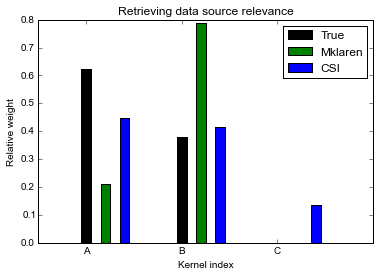

In [51]:
# Plot the retrieved coefficients
step = 0.2
x1 = np.arange(len(mu))
x2 = np.arange(len(mu)) + step
x3 = np.arange(len(mu)) + 2 * step

plt.figure()
plt.bar(x1, mu / mu.sum(), align="center", width=step/2, color="black", label="True")
plt.bar(x2, mu_mkl / mu_mkl.sum(), align="center", width=step/2, color="green", label="Mklaren")
plt.bar(x3, mu_chol / mu_chol.sum(), align="center", width=step/2, color="blue", label="CSI")
plt.plot([-0.5, 3], [0, 0], color="black")
plt.xticks(x1)
plt.gca().set_xticklabels(["A", "B", "C"])

plt.legend()
plt.title("Retrieving data source relevance")
plt.ylabel("Relative weight")
plt.xlabel("Kernel index")
plt.show()